In [1]:
import pandas as pd

df = pd.read_parquet("../data/dataframe.br.parq", engine="pyarrow")

### Set global vars

In [167]:
from collections import namedtuple, defaultdict

LeaderboardSetting = namedtuple(
    "LeaderboardSetting", "game leaderboard legend url bit_mask"
)

GLOBAL_SETTINGS = {
    "ACTIVITY_PERIODS": [30,14,7,3,1],
    "GAMES": ["aoe2", "aoe3", "aoe4"],
    "TOP_COUNTRIES": 25,
    "LEADERBOARD_SETTINGS": [
    LeaderboardSetting(
        "aoe2",
        "rm",
        "AoE2:DE RM",
        "https://aoe2.net/leaderboard/aoe2de/rm-1v1?draw=1&columns[0][data]=&columns[0][name]=&columns[0][searchable]=false&columns[0][orderable]=true&columns[0][search][value]=&columns[0][search][regex]=false&columns[1][data]=&columns[1][name]=&columns[1][searchable]=false&columns[1][orderable]=true&columns[1][search][value]=&columns[1][search][regex]=false&columns[2][data]=&columns[2][name]=&columns[2][searchable]=true&columns[2][orderable]=true&columns[2][search][value]=&columns[2][search][regex]=false&columns[3][data]=&columns[3][name]=&columns[3][searchable]=false&columns[3][orderable]=true&columns[3][search][value]=&columns[3][search][regex]=false&columns[4][data]=&columns[4][name]=&columns[4][searchable]=false&columns[4][orderable]=true&columns[4][search][value]=&columns[4][search][regex]=false&columns[5][data]=&columns[5][name]=&columns[5][searchable]=false&columns[5][orderable]=true&columns[5][search][value]=&columns[5][search][regex]=false&columns[6][data]=&columns[6][name]=&columns[6][searchable]=false&columns[6][orderable]=true&columns[6][search][value]=&columns[6][search][regex]=false&columns[7][data]=&columns[7][name]=&columns[7][searchable]=false&columns[7][orderable]=true&columns[7][search][value]=&columns[7][search][regex]=false&order[0][column]=0&order[0][dir]=asc&search[value]=&search[regex]=false",
        0b1,
    ),
    LeaderboardSetting(
        "aoe2",
        "team_rm",
        "AoE2:DE Team-RM",
        "https://aoe2.net/leaderboard/aoe2de/rm-team?draw=2&columns[0][data]=&columns[0][name]=&columns[0][searchable]=false&columns[0][orderable]=true&columns[0][search][value]=&columns[0][search][regex]=false&columns[1][data]=&columns[1][name]=&columns[1][searchable]=false&columns[1][orderable]=true&columns[1][search][value]=&columns[1][search][regex]=false&columns[2][data]=&columns[2][name]=&columns[2][searchable]=true&columns[2][orderable]=true&columns[2][search][value]=&columns[2][search][regex]=false&columns[3][data]=&columns[3][name]=&columns[3][searchable]=false&columns[3][orderable]=true&columns[3][search][value]=&columns[3][search][regex]=false&columns[4][data]=&columns[4][name]=&columns[4][searchable]=false&columns[4][orderable]=true&columns[4][search][value]=&columns[4][search][regex]=false&columns[5][data]=&columns[5][name]=&columns[5][searchable]=false&columns[5][orderable]=true&columns[5][search][value]=&columns[5][search][regex]=false&columns[6][data]=&columns[6][name]=&columns[6][searchable]=false&columns[6][orderable]=true&columns[6][search][value]=&columns[6][search][regex]=false&columns[7][data]=&columns[7][name]=&columns[7][searchable]=false&columns[7][orderable]=true&columns[7][search][value]=&columns[7][search][regex]=false&order[0][column]=0&order[0][dir]=asc&search[value]=&search[regex]=false",
        0b10,
    ),
    LeaderboardSetting(
        "aoe2",
        "ew",
        "AoE2:DE EW",
        "https://aoe2.net/leaderboard/aoe2de/ew-1v1?draw=4&columns[0][data]=&columns[0][name]=&columns[0][searchable]=false&columns[0][orderable]=true&columns[0][search][value]=&columns[0][search][regex]=false&columns[1][data]=&columns[1][name]=&columns[1][searchable]=false&columns[1][orderable]=true&columns[1][search][value]=&columns[1][search][regex]=false&columns[2][data]=&columns[2][name]=&columns[2][searchable]=true&columns[2][orderable]=true&columns[2][search][value]=&columns[2][search][regex]=false&columns[3][data]=&columns[3][name]=&columns[3][searchable]=false&columns[3][orderable]=true&columns[3][search][value]=&columns[3][search][regex]=false&columns[4][data]=&columns[4][name]=&columns[4][searchable]=false&columns[4][orderable]=true&columns[4][search][value]=&columns[4][search][regex]=false&columns[5][data]=&columns[5][name]=&columns[5][searchable]=false&columns[5][orderable]=true&columns[5][search][value]=&columns[5][search][regex]=false&columns[6][data]=&columns[6][name]=&columns[6][searchable]=false&columns[6][orderable]=true&columns[6][search][value]=&columns[6][search][regex]=false&columns[7][data]=&columns[7][name]=&columns[7][searchable]=false&columns[7][orderable]=true&columns[7][search][value]=&columns[7][search][regex]=false&order[0][column]=0&order[0][dir]=asc&search[value]=&search[regex]=false",
        0b100,
    ),
    LeaderboardSetting(
        "aoe2",
        "team_ew",
        "AoE2:DE Team-EW",
        "https://aoe2.net/leaderboard/aoe2de/ew-team?draw=3&columns[0][data]=&columns[0][name]=&columns[0][searchable]=false&columns[0][orderable]=true&columns[0][search][value]=&columns[0][search][regex]=false&columns[1][data]=&columns[1][name]=&columns[1][searchable]=false&columns[1][orderable]=true&columns[1][search][value]=&columns[1][search][regex]=false&columns[2][data]=&columns[2][name]=&columns[2][searchable]=true&columns[2][orderable]=true&columns[2][search][value]=&columns[2][search][regex]=false&columns[3][data]=&columns[3][name]=&columns[3][searchable]=false&columns[3][orderable]=true&columns[3][search][value]=&columns[3][search][regex]=false&columns[4][data]=&columns[4][name]=&columns[4][searchable]=false&columns[4][orderable]=true&columns[4][search][value]=&columns[4][search][regex]=false&columns[5][data]=&columns[5][name]=&columns[5][searchable]=false&columns[5][orderable]=true&columns[5][search][value]=&columns[5][search][regex]=false&columns[6][data]=&columns[6][name]=&columns[6][searchable]=false&columns[6][orderable]=true&columns[6][search][value]=&columns[6][search][regex]=false&columns[7][data]=&columns[7][name]=&columns[7][searchable]=false&columns[7][orderable]=true&columns[7][search][value]=&columns[7][search][regex]=false&order[0][column]=0&order[0][dir]=asc&search[value]=&search[regex]=false",
        0b1000,
    ),
    LeaderboardSetting(
        "aoe2",
        "unranked",
        "AoE2:DE Unranked",
        "https://aoe2.net/leaderboard/aoe2de/unranked?draw=5&columns[0][data]=&columns[0][name]=&columns[0][searchable]=false&columns[0][orderable]=true&columns[0][search][value]=&columns[0][search][regex]=false&columns[1][data]=&columns[1][name]=&columns[1][searchable]=false&columns[1][orderable]=true&columns[1][search][value]=&columns[1][search][regex]=false&columns[2][data]=&columns[2][name]=&columns[2][searchable]=true&columns[2][orderable]=true&columns[2][search][value]=&columns[2][search][regex]=false&columns[3][data]=&columns[3][name]=&columns[3][searchable]=false&columns[3][orderable]=true&columns[3][search][value]=&columns[3][search][regex]=false&columns[4][data]=&columns[4][name]=&columns[4][searchable]=false&columns[4][orderable]=true&columns[4][search][value]=&columns[4][search][regex]=false&columns[5][data]=&columns[5][name]=&columns[5][searchable]=false&columns[5][orderable]=true&columns[5][search][value]=&columns[5][search][regex]=false&columns[6][data]=&columns[6][name]=&columns[6][searchable]=false&columns[6][orderable]=true&columns[6][search][value]=&columns[6][search][regex]=false&columns[7][data]=&columns[7][name]=&columns[7][searchable]=false&columns[7][orderable]=true&columns[7][search][value]=&columns[7][search][regex]=false&order[0][column]=0&order[0][dir]=asc&search[value]=&search[regex]=false",
        0b10000,
    ),
    LeaderboardSetting(
        "aoe3",
        "supremacy_1v1",
        "AoE3:DE Supremacy 1v1",
        "https://aoe3.net/leaderboard/aoe3de/supremacy-1v1?draw=1&columns[0][data]=&columns[0][name]=&columns[0][searchable]=false&columns[0][orderable]=true&columns[0][search][value]=&columns[0][search][regex]=false&columns[1][data]=&columns[1][name]=&columns[1][searchable]=false&columns[1][orderable]=true&columns[1][search][value]=&columns[1][search][regex]=false&columns[2][data]=&columns[2][name]=&columns[2][searchable]=true&columns[2][orderable]=true&columns[2][search][value]=&columns[2][search][regex]=false&columns[3][data]=&columns[3][name]=&columns[3][searchable]=false&columns[3][orderable]=true&columns[3][search][value]=&columns[3][search][regex]=false&columns[4][data]=&columns[4][name]=&columns[4][searchable]=false&columns[4][orderable]=true&columns[4][search][value]=&columns[4][search][regex]=false&columns[5][data]=&columns[5][name]=&columns[5][searchable]=false&columns[5][orderable]=true&columns[5][search][value]=&columns[5][search][regex]=false&columns[6][data]=&columns[6][name]=&columns[6][searchable]=false&columns[6][orderable]=true&columns[6][search][value]=&columns[6][search][regex]=false&columns[7][data]=&columns[7][name]=&columns[7][searchable]=false&columns[7][orderable]=true&columns[7][search][value]=&columns[7][search][regex]=false&order[0][column]=0&order[0][dir]=asc&search[value]=&search[regex]=false",
        0b100000,
    ),
    LeaderboardSetting(
        "aoe3",
        "supremacy_team",
        "AoE3:DE Supremacy Team",
        "https://aoe3.net/leaderboard/aoe3de/supremacy-team?draw=2&columns[0][data]=&columns[0][name]=&columns[0][searchable]=false&columns[0][orderable]=true&columns[0][search][value]=&columns[0][search][regex]=false&columns[1][data]=&columns[1][name]=&columns[1][searchable]=false&columns[1][orderable]=true&columns[1][search][value]=&columns[1][search][regex]=false&columns[2][data]=&columns[2][name]=&columns[2][searchable]=true&columns[2][orderable]=true&columns[2][search][value]=&columns[2][search][regex]=false&columns[3][data]=&columns[3][name]=&columns[3][searchable]=false&columns[3][orderable]=true&columns[3][search][value]=&columns[3][search][regex]=false&columns[4][data]=&columns[4][name]=&columns[4][searchable]=false&columns[4][orderable]=true&columns[4][search][value]=&columns[4][search][regex]=false&columns[5][data]=&columns[5][name]=&columns[5][searchable]=false&columns[5][orderable]=true&columns[5][search][value]=&columns[5][search][regex]=false&columns[6][data]=&columns[6][name]=&columns[6][searchable]=false&columns[6][orderable]=true&columns[6][search][value]=&columns[6][search][regex]=false&columns[7][data]=&columns[7][name]=&columns[7][searchable]=false&columns[7][orderable]=true&columns[7][search][value]=&columns[7][search][regex]=false&order[0][column]=0&order[0][dir]=asc&search[value]=&search[regex]=false",
        0b1000000,
    ),
    LeaderboardSetting(
        "aoe3",
        "treaty",
        "AoE3:DE Treaty",
        "https://aoe3.net/leaderboard/aoe3de/treaty?draw=3&columns[0][data]=&columns[0][name]=&columns[0][searchable]=false&columns[0][orderable]=true&columns[0][search][value]=&columns[0][search][regex]=false&columns[1][data]=&columns[1][name]=&columns[1][searchable]=false&columns[1][orderable]=true&columns[1][search][value]=&columns[1][search][regex]=false&columns[2][data]=&columns[2][name]=&columns[2][searchable]=true&columns[2][orderable]=true&columns[2][search][value]=&columns[2][search][regex]=false&columns[3][data]=&columns[3][name]=&columns[3][searchable]=false&columns[3][orderable]=true&columns[3][search][value]=&columns[3][search][regex]=false&columns[4][data]=&columns[4][name]=&columns[4][searchable]=false&columns[4][orderable]=true&columns[4][search][value]=&columns[4][search][regex]=false&columns[5][data]=&columns[5][name]=&columns[5][searchable]=false&columns[5][orderable]=true&columns[5][search][value]=&columns[5][search][regex]=false&columns[6][data]=&columns[6][name]=&columns[6][searchable]=false&columns[6][orderable]=true&columns[6][search][value]=&columns[6][search][regex]=false&columns[7][data]=&columns[7][name]=&columns[7][searchable]=false&columns[7][orderable]=true&columns[7][search][value]=&columns[7][search][regex]=false&order[0][column]=0&order[0][dir]=asc&search[value]=&search[regex]=false",
        0b10000000,
    ),
    LeaderboardSetting(
        "aoe3",
        "deathmatch",
        "AoE3:DE Deathmatch",
        "https://aoe3.net/leaderboard/aoe3de/deathmatch?draw=4&columns[0][data]=&columns[0][name]=&columns[0][searchable]=false&columns[0][orderable]=true&columns[0][search][value]=&columns[0][search][regex]=false&columns[1][data]=&columns[1][name]=&columns[1][searchable]=false&columns[1][orderable]=true&columns[1][search][value]=&columns[1][search][regex]=false&columns[2][data]=&columns[2][name]=&columns[2][searchable]=true&columns[2][orderable]=true&columns[2][search][value]=&columns[2][search][regex]=false&columns[3][data]=&columns[3][name]=&columns[3][searchable]=false&columns[3][orderable]=true&columns[3][search][value]=&columns[3][search][regex]=false&columns[4][data]=&columns[4][name]=&columns[4][searchable]=false&columns[4][orderable]=true&columns[4][search][value]=&columns[4][search][regex]=false&columns[5][data]=&columns[5][name]=&columns[5][searchable]=false&columns[5][orderable]=true&columns[5][search][value]=&columns[5][search][regex]=false&columns[6][data]=&columns[6][name]=&columns[6][searchable]=false&columns[6][orderable]=true&columns[6][search][value]=&columns[6][search][regex]=false&columns[7][data]=&columns[7][name]=&columns[7][searchable]=false&columns[7][orderable]=true&columns[7][search][value]=&columns[7][search][regex]=false&order[0][column]=0&order[0][dir]=asc&search[value]=&search[regex]=false",
        0b100000000,
    ),
    LeaderboardSetting(
        "aoe4",
        "custom",
        "AoE4 Custom",
        "https://aoeiv.net/leaderboard/aoe4/custom?draw=2&columns[0][data]=&columns[0][name]=&columns[0][searchable]=false&columns[0][orderable]=true&columns[0][search][value]=&columns[0][search][regex]=false&columns[1][data]=&columns[1][name]=&columns[1][searchable]=false&columns[1][orderable]=true&columns[1][search][value]=&columns[1][search][regex]=false&columns[2][data]=&columns[2][name]=&columns[2][searchable]=true&columns[2][orderable]=true&columns[2][search][value]=&columns[2][search][regex]=false&columns[3][data]=&columns[3][name]=&columns[3][searchable]=false&columns[3][orderable]=true&columns[3][search][value]=&columns[3][search][regex]=false&columns[4][data]=&columns[4][name]=&columns[4][searchable]=false&columns[4][orderable]=true&columns[4][search][value]=&columns[4][search][regex]=false&columns[5][data]=&columns[5][name]=&columns[5][searchable]=false&columns[5][orderable]=true&columns[5][search][value]=&columns[5][search][regex]=false&columns[6][data]=&columns[6][name]=&columns[6][searchable]=false&columns[6][orderable]=true&columns[6][search][value]=&columns[6][search][regex]=false&columns[7][data]=&columns[7][name]=&columns[7][searchable]=false&columns[7][orderable]=true&columns[7][search][value]=&columns[7][search][regex]=false&order[0][column]=0&order[0][dir]=asc&search[value]=&search[regex]=false",
        0b1000000000,
    ),
    LeaderboardSetting(
        "aoe4",
        "qm_1v1",
        "AoE4 QM-1v1",
        "https://aoeiv.net/leaderboard/aoe4/qm-1v1?draw=1&columns[0][data]=&columns[0][name]=&columns[0][searchable]=false&columns[0][orderable]=true&columns[0][search][value]=&columns[0][search][regex]=false&columns[1][data]=&columns[1][name]=&columns[1][searchable]=false&columns[1][orderable]=true&columns[1][search][value]=&columns[1][search][regex]=false&columns[2][data]=&columns[2][name]=&columns[2][searchable]=true&columns[2][orderable]=true&columns[2][search][value]=&columns[2][search][regex]=false&columns[3][data]=&columns[3][name]=&columns[3][searchable]=false&columns[3][orderable]=true&columns[3][search][value]=&columns[3][search][regex]=false&columns[4][data]=&columns[4][name]=&columns[4][searchable]=false&columns[4][orderable]=true&columns[4][search][value]=&columns[4][search][regex]=false&columns[5][data]=&columns[5][name]=&columns[5][searchable]=false&columns[5][orderable]=true&columns[5][search][value]=&columns[5][search][regex]=false&columns[6][data]=&columns[6][name]=&columns[6][searchable]=false&columns[6][orderable]=true&columns[6][search][value]=&columns[6][search][regex]=false&columns[7][data]=&columns[7][name]=&columns[7][searchable]=false&columns[7][orderable]=true&columns[7][search][value]=&columns[7][search][regex]=false&order[0][column]=0&order[0][dir]=asc&search[value]=&search[regex]=false",
        0b10000000000,
    ),
    LeaderboardSetting(
        "aoe4",
        "qm_2v2",
        "AoE4 QM-2v2",
        "https://aoeiv.net/leaderboard/aoe4/qm-2v2?draw=3&columns[0][data]=&columns[0][name]=&columns[0][searchable]=false&columns[0][orderable]=true&columns[0][search][value]=&columns[0][search][regex]=false&columns[1][data]=&columns[1][name]=&columns[1][searchable]=false&columns[1][orderable]=true&columns[1][search][value]=&columns[1][search][regex]=false&columns[2][data]=&columns[2][name]=&columns[2][searchable]=true&columns[2][orderable]=true&columns[2][search][value]=&columns[2][search][regex]=false&columns[3][data]=&columns[3][name]=&columns[3][searchable]=false&columns[3][orderable]=true&columns[3][search][value]=&columns[3][search][regex]=false&columns[4][data]=&columns[4][name]=&columns[4][searchable]=false&columns[4][orderable]=true&columns[4][search][value]=&columns[4][search][regex]=false&columns[5][data]=&columns[5][name]=&columns[5][searchable]=false&columns[5][orderable]=true&columns[5][search][value]=&columns[5][search][regex]=false&columns[6][data]=&columns[6][name]=&columns[6][searchable]=false&columns[6][orderable]=true&columns[6][search][value]=&columns[6][search][regex]=false&columns[7][data]=&columns[7][name]=&columns[7][searchable]=false&columns[7][orderable]=true&columns[7][search][value]=&columns[7][search][regex]=false&order[0][column]=0&order[0][dir]=asc&search[value]=&search[regex]=false",
        0b100000000000,
    ),
    LeaderboardSetting(
        "aoe4",
        "qm_3v3",
        "AoE4 QM-3v3",
        "https://aoeiv.net/leaderboard/aoe4/qm-3v3?draw=4&columns[0][data]=&columns[0][name]=&columns[0][searchable]=false&columns[0][orderable]=true&columns[0][search][value]=&columns[0][search][regex]=false&columns[1][data]=&columns[1][name]=&columns[1][searchable]=false&columns[1][orderable]=true&columns[1][search][value]=&columns[1][search][regex]=false&columns[2][data]=&columns[2][name]=&columns[2][searchable]=true&columns[2][orderable]=true&columns[2][search][value]=&columns[2][search][regex]=false&columns[3][data]=&columns[3][name]=&columns[3][searchable]=false&columns[3][orderable]=true&columns[3][search][value]=&columns[3][search][regex]=false&columns[4][data]=&columns[4][name]=&columns[4][searchable]=false&columns[4][orderable]=true&columns[4][search][value]=&columns[4][search][regex]=false&columns[5][data]=&columns[5][name]=&columns[5][searchable]=false&columns[5][orderable]=true&columns[5][search][value]=&columns[5][search][regex]=false&columns[6][data]=&columns[6][name]=&columns[6][searchable]=false&columns[6][orderable]=true&columns[6][search][value]=&columns[6][search][regex]=false&columns[7][data]=&columns[7][name]=&columns[7][searchable]=false&columns[7][orderable]=true&columns[7][search][value]=&columns[7][search][regex]=false&order[0][column]=0&order[0][dir]=asc&search[value]=&search[regex]=false",
        0b1000000000000,
    ),
    LeaderboardSetting(
        "aoe4",
        "qm_4v4",
        "AoE4 QM-4v4",
        "https://aoeiv.net/leaderboard/aoe4/qm-4v4?draw=5&columns[0][data]=&columns[0][name]=&columns[0][searchable]=false&columns[0][orderable]=true&columns[0][search][value]=&columns[0][search][regex]=false&columns[1][data]=&columns[1][name]=&columns[1][searchable]=false&columns[1][orderable]=true&columns[1][search][value]=&columns[1][search][regex]=false&columns[2][data]=&columns[2][name]=&columns[2][searchable]=true&columns[2][orderable]=true&columns[2][search][value]=&columns[2][search][regex]=false&columns[3][data]=&columns[3][name]=&columns[3][searchable]=false&columns[3][orderable]=true&columns[3][search][value]=&columns[3][search][regex]=false&columns[4][data]=&columns[4][name]=&columns[4][searchable]=false&columns[4][orderable]=true&columns[4][search][value]=&columns[4][search][regex]=false&columns[5][data]=&columns[5][name]=&columns[5][searchable]=false&columns[5][orderable]=true&columns[5][search][value]=&columns[5][search][regex]=false&columns[6][data]=&columns[6][name]=&columns[6][searchable]=false&columns[6][orderable]=true&columns[6][search][value]=&columns[6][search][regex]=false&columns[7][data]=&columns[7][name]=&columns[7][searchable]=false&columns[7][orderable]=true&columns[7][search][value]=&columns[7][search][regex]=false&order[0][column]=0&order[0][dir]=asc&search[value]=&search[regex]=false",
        0b10000000000000,
    ),
    ],
}


# Mask for only having the last timestamp
LAST_TIMESTAMP = df['timestamp'] == df['timestamp'].max()

# Latest dataset
lt_df=df[LAST_TIMESTAMP]

activity_filters_lt = pd.DataFrame()

for activity_period in GLOBAL_SETTINGS["ACTIVITY_PERIODS"]:
    activity_filters_lt[f"{activity_period}d"] = ((lt_df['timestamp']-lt_df['last_match']) < pd.Timedelta(activity_period, "d"))

# Create a dict with the activity periods for game and leaderboards
ACTIVITY_GL_GROUPS = {}

for activity_period in GLOBAL_SETTINGS["ACTIVITY_PERIODS"]:
   ACTIVITY_GL_GROUPS[f"{activity_period}d"] = lt_df[activity_filters_lt[f"{activity_period}d"]].groupby(["game", "leaderboard"])

# Create a dict with the activity periods for games
ACTIVITY_GAME_GROUPS = {}

# TODO: Think through if this really does what it should:
# It groups by the game, later we use the `profile_id` field,
# which can exist multiple times in this group, we make it unique
# by using value_counts on it and count it as one profile if in the activity span
# This should be essentially what it should be.
for activity_period in GLOBAL_SETTINGS["ACTIVITY_PERIODS"]:
   ACTIVITY_GAME_GROUPS[f"{activity_period}d"] = lt_df[activity_filters_lt[f"{activity_period}d"]].groupby(["game"])

# Create a dict with the activity periods for profiles
ACTIVITY_PROFILE_GROUPS = {}

for activity_period in GLOBAL_SETTINGS["ACTIVITY_PERIODS"]:
   ACTIVITY_PROFILE_GROUPS[f"{activity_period}d"] = lt_df[activity_filters_lt[f"{activity_period}d"]].groupby(["profile_id"])



def initialise_defaultdict_recursive():
    return defaultdict(initialise_defaultdict_recursive)


In [171]:
ACTIVITY_GL_GROUPS
ACTIVITY_GAME_GROUPS
ACTIVITY_PROFILE_GROUPS["1d"].head()

,timestamp,game,leaderboard,steam_id,profile_id,rank,rating,highest_rating,previous_rating,country_code,name,known_name,num_games,streak,num_wins,win_percent,rating24h,games24h,wins24h,last_match
2478285,2022-01-31 08:26:48.290235,aoe2,rm,"b'\x14e\xc6""\xf6\xc2U.\xeb\x96S1@\xe0JSLS\x96\...",b'\xd1c\xaf\xef\xbfev\x88\xff\x8c\xe1HU\xccl\x...,6,2469,2485.0,2465.0,BE,"b""\xf7}HA1\xb6\xc3\xc82:\x1c'y\xc8r\xd1\x0e\x1...",b'n\xc6K\xcd\xc5\x98\xfen-\xb2p?\xf8\xc5\xbd\x...,3315,17,1936,58,4,1,1,2022-01-30 13:33:08
2478287,2022-01-31 08:26:48.290235,aoe2,rm,b'*(\x9fP\xf7F\xcc*\x8a\x15\x93%\xce)4zU\xde\x...,b'N.\x1e\x81\x05\x17Bi\xd1]\x9337V\xdd\x1ce\x9...,8,2462,2470.0,2458.0,PL,b'\x1a\x88u\xb5\xc2E\x0e{\xef\xce\xb2c\xf1\xd9...,b'n\xc6K\xcd\xc5\x98\xfen-\xb2p?\xf8\xc5\xbd\x...,1805,1,1118,62,4,1,1,2022-01-30 15:40:32
2478297,2022-01-31 08:26:48.290235,aoe2,rm,b'\x17~\x8a\xad\x89*\xdf#\xbd\xfe\xa0<\xfa\xaf...,b'\xb2;\xc4*\xce_\xc1\x02z\x88\xc7.\xcf\x9c\xf...,18,2425,2506.0,2423.0,BR,b'\xb7`\x91\x04[\xc0cDVQ\xb3\x99\xba\xee\xd2\x...,b'n\xc6K\xcd\xc5\x98\xfen-\xb2p?\xf8\xc5\xbd\x...,1150,9,827,72,11,4,4,2022-01-31 00:08:53
2478300,2022-01-31 08:26:48.290235,aoe2,rm,b'a[E\xa4\xdf\xd9\x1a\xef\x9cv\xfc[\xa0J#\t\xc...,b'\x9b\xbb\x95\xe8\x8e\t\xf5C1b\\\xf9\x16\x83[...,21,2412,2498.0,2405.0,RU,b']\xbar\xfd4tL\x93\xe2=\xbc\xc1()=!\x02\x13\x...,b'n\xc6K\xcd\xc5\x98\xfen-\xb2p?\xf8\xc5\xbd\x...,991,2,658,66,7,2,2,2022-01-30 11:48:50
2478310,2022-01-31 08:26:48.290235,aoe2,rm,"b',\x95\x85M\x9e\xd5\xf3\xb7\x8e9a\xb7\xdd\xd4...",b'\xb6{A\x97I\xbc\x19\xbb\xb5\xe1\xd0\xb4$\xd5...,31,2355,2402.0,2365.0,ES,b'\xf50\x9d\xbe\x85-\xea\x81\x99\x0f\xd8\xb2\x...,b'n\xc6K\xcd\xc5\x98\xfen-\xb2p?\xf8\xc5\xbd\x...,943,-1,598,63,-10,1,0,2022-01-30 11:18:28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3095288,2022-01-31 08:26:48.290235,aoe4,qm_4v4,b';\xd9\x12S\xcbC\xdc\x82<\xff\x8b\xec\xce\x8e...,b'\xd9\x03\x1e/\x18iC\x93\xc9\x1d\x1b\x10\xde0...,44729,413,827.0,429.0,None,b'\xbc\x95\xfa\x18\x0e\xc3\xf6\xac\xccZ3\xa1\x...,None,101,-1,34,34,-3,2,1,2022-01-30 16:24:23
3095289,2022-01-31 08:26:48.290235,aoe4,qm_4v4,None,b'z\xc1\x11gl\xe8\x15\x8a\x13\xff\x0c\x91{\xeb...,44730,410,857.0,425.0,None,b'2\t\xcd!\xc7=\x92\x96\xcd\xdc\xc5>\x86\x19\x...,None,349,-3,129,37,-26,10,3,2022-01-31 02:00:01
3095290,2022-01-31 08:26:48.290235,aoe4,qm_4v4,b'\x19\xe0Y1^&FZ\xdc\xb9ez#\xbd\xeeAuIn\xf5\xe...,b'{\xb3\x0e\x0fs\x16z\x81\xb02\xe3>\xaa\x03\xa...,44731,408,865.0,392.0,None,b'\xd2\x13\xec\t\xaf`\x0b\x8c\\;`]d\x03i\x80|\...,None,169,1,65,38,16,1,1,2022-01-30 16:24:23
3095291,2022-01-31 08:26:48.290235,aoe4,qm_4v4,b'\xe9\x18\x98\xe7svZ\xdb\x91\xa0\x04\x81\x0bd...,"b""\xca\xf2\xc3i\xd8`V\xe5'\xaf7\x02\x05 \x83\x...",44732,406,993.0,421.0,None,b'U\xcf1\xf7\xf4\x99\x85\xf22\x87_\x11\x7f\xf5...,None,208,-2,79,38,-47,6,1,2022-01-30 14:18:16


### Some information about the data

In [39]:
df.columns

Index(['timestamp', 'game', 'leaderboard', 'steam_id', 'profile_id', 'rank',
       'rating', 'highest_rating', 'previous_rating', 'country_code', 'name',
       'known_name', 'num_games', 'streak', 'num_wins', 'win_percent',
       'rating24h', 'games24h', 'wins24h', 'last_match'],
      dtype='object')

In [19]:
# DF size
df.shape
# Normal information
gl_lt_df.describe()

rank                                                 \
                        count     mean           std  min       25%      50%   
game leaderboard                                                               
aoe2 ew                1813.0    907.0    523.512337  1.0    454.00    907.0   
     rm               40045.0  20023.0  11560.140102  1.0  10012.00  20023.0   
     team_ew           2433.0   1217.0    702.490925  1.0    609.00   1217.0   
     team_rm          65119.0  32560.0  18798.380427  1.0  16280.50  32560.0   
     unranked        172525.0  86263.0  49803.821933  1.0  43132.00  86263.0   
aoe3 deathmatch          23.0     12.0      6.782330  1.0      6.50     12.0   
     supremacy_1v1     2987.0   1494.0    862.416953  1.0    747.50   1494.0   
     supremacy_team    2885.0   1443.0    832.972088  1.0    722.00   1443.0   
     treaty             613.0    307.0    177.102136  1.0    154.00    307.0   
aoe4 custom          130580.0  65290.5  37695.343413  1.0  32645.75  65290.5   
     qm_1v1           43623.0  21812.0  12593.019733  1.0  10906.50  21812.0   
     qm_2v2           56827.0  28414.0  16404.686211  1.0  14207.50  28414.0   
     qm_3v3           52807.0  26404.0  15244.212169  1.0  13202.50  26404.0   
     qm_4v4           44735.0  22368.0  12914.026483  1.0  11184.50  22368.0   

                                            rating               ... games24h  \
                           75%       max     count         mean  ...      75%   
game leaderboard                                                 ...            
aoe2 ew                1360.00    1813.0    1813.0  1002.599007  ...      0.0   
     rm               30034.00   40045.0   40045.0  1041.058884  ...      0.0   
     team_ew           1825.00    2433.0    2433.0  1010.758323  ...      0.0   
     team_rm          48839.50   65119.0   65119.0  1406.511571  ...      1.0   
     unranked        129394.00  172525.0  172525.0  1202.636690  ...      0.0   
aoe3 deathmatch          17.50      23.0      23.0  1294.391304  ...      1.0   
     supremacy_1v1     2240.50    2987.0    2987.0  1090.173418  ...      0.0   
     supremacy_team    2164.00    2885.0    2885.0  1252.786135  ...      0.0   
     treaty             460.00     613.0     613.0  1131.743883  ...      0.0   
aoe4 custom           97935.25  130580.0  130580.0   999.268724  ...      0.0   
     qm_1v1           32717.50   43623.0   43623.0  1002.117965  ...      0.0   
     qm_2v2           42620.50   56827.0   56827.0   998.244057  ...      0.0   
     qm_3v3           39605.50   52807.0   52807.0   996.145738  ...      0.0   
     qm_4v4           33551.50   44735.0   44735.0   996.263396  ...      0.0   

                            wins24h                                          \
                      max     count      mean       std  min  25%  50%  75%   
game leaderboard                                                              
aoe2 ew              28.0    1813.0  0.294539  0.987425  0.0  0.0  0.0  0.0   
     rm              40.0   40045.0  0.423149  1.129940  0.0  0.0  0.0  0.0   
     team_ew         21.0    2433.0  0.169749  0.608632  0.0  0.0  0.0  0.0   
     team_rm         40.0   65119.0  0.481733  1.167267  0.0  0.0  0.0  0.0   
     unranked         0.0  172525.0  0.000000  0.000000  0.0  0.0  0.0  0.0   
aoe3 deathmatch       7.0      23.0  0.521739  1.503619  0.0  0.0  0.0  0.0   
     supremacy_1v1   38.0    2987.0  0.598259  1.711815  0.0  0.0  0.0  0.0   
     supremacy_team  22.0    2885.0  0.438475  1.241661  0.0  0.0  0.0  0.0   
     treaty          15.0     613.0  0.213703  0.801352  0.0  0.0  0.0  0.0   
aoe4 custom          74.0  130580.0  0.229920  0.754152  0.0  0.0  0.0  0.0   
     qm_1v1          42.0   43623.0  0.428352  1.180704  0.0  0.0  0.0  0.0   
     qm_2v2          23.0   56827.0  0.273022  0.814523  0.0  0.0  0.0  0.0   
     qm_3v3          22.0   52807.0  0.241426  0.741464  0.0  0.0  0.0  0.0   
     qm_4v4          2

# TODO

# data_analyser.countries_per_game()
# data_analyser.countries_for_franchise()
# data_analyser.platforms_per_leaderboard()
# data_analyser.platforms_per_game()
# data_analyser.platforms_for_franchise()

In [103]:
# data_analyser.calculate_leaderboard_activity()

leaderboard_activity = initialise_defaultdict_recursive()

for game, leaderboard, _, _, _, in GLOBAL_SETTINGS["LEADERBOARD_SETTINGS"]:
    for activity_period in GLOBAL_SETTINGS["ACTIVITY_PERIODS"]:
        try:
            leaderboard_activity[f"{activity_period}d"][game][leaderboard]=ACTIVITY_GL_GROUPS[f"{activity_period}d"].get_group((game, leaderboard))["profile_id"].value_counts().sum()
        except (KeyError):
            leaderboard_activity[f"{activity_period}d"][game][leaderboard]=None

print(leaderboard_activity)

defaultdict(<function initialise_defaultdict_recursive at 0x00000297B0551F30>, {'30d': defaultdict(<function initialise_defaultdict_recursive at 0x00000297B0551F30>, {'aoe2': defaultdict(<function initialise_defaultdict_recursive at 0x00000297B0551F30>, {'rm': 40045, 'team_rm': 65119, 'ew': 1813, 'team_ew': 2433, 'unranked': 89532}), 'aoe3': defaultdict(<function initialise_defaultdict_recursive at 0x00000297B0551F30>, {'supremacy_1v1': 2987, 'supremacy_team': 2885, 'treaty': 613, 'deathmatch': 23}), 'aoe4': defaultdict(<function initialise_defaultdict_recursive at 0x00000297B0551F30>, {'custom': 130579, 'qm_1v1': 43623, 'qm_2v2': 56827, 'qm_3v3': 52807, 'qm_4v4': 44735})}), '14d': defaultdict(<function initialise_defaultdict_recursive at 0x00000297B0551F30>, {'aoe2': defaultdict(<function initialise_defaultdict_recursive at 0x00000297B0551F30>, {'rm': 31559, 'team_rm': 52778, 'ew': 1312, 'team_ew': 1785, 'unranked': None}), 'aoe3': defaultdict(<function initialise_defaultdict_recursiv

In [146]:
# data_analyser.calculate_game_activity()

game_activity = initialise_defaultdict_recursive()

# Overall unique franchise player numbers of all leaderboards and games within the time period of X 
for game in GLOBAL_SETTINGS["GAMES"]:
    for activity_period in GLOBAL_SETTINGS["ACTIVITY_PERIODS"]:
        try:
            if isinstance(game_activity[f"{activity_period}d"][game], defaultdict):
                game_activity[f"{activity_period}d"][game]=0
            game_activity[f"{activity_period}d"][game]=ACTIVITY_GAME_GROUPS[f"{activity_period}d"][["profile_id"]].get_group(game).value_counts().sum()
        except (KeyError):
            # happens because the unranked leaderboard has no activity
            # we can pass this run
            pass

print(game_activity)

defaultdict(<function initialise_defaultdict_recursive at 0x000002982DAD6EF0>, {'30d': defaultdict(<function initialise_defaultdict_recursive at 0x000002982DAD6EF0>, {'aoe2': 198942, 'aoe3': 6508, 'aoe4': 328571}), '14d': defaultdict(<function initialise_defaultdict_recursive at 0x000002982DAD6EF0>, {'aoe2': 87434, 'aoe3': 4917, 'aoe4': 237526}), '7d': defaultdict(<function initialise_defaultdict_recursive at 0x000002982DAD6EF0>, {'aoe2': 68823, 'aoe3': 3751, 'aoe4': 175292}), '3d': defaultdict(<function initialise_defaultdict_recursive at 0x000002982DAD6EF0>, {'aoe2': 50643, 'aoe3': 2686, 'aoe4': 123238}), '1d': defaultdict(<function initialise_defaultdict_recursive at 0x000002982DAD6EF0>, {'aoe2': 29184, 'aoe3': 1563, 'aoe4': 66361})})


In [154]:
# data_analyser.calculate_franchise_activity()

# Overall unique franchise player numbers of all leaderboards and games within the time period of X
franchise_activity = {}
for activity_period in GLOBAL_SETTINGS["ACTIVITY_PERIODS"]:
    franchise_activity[f"{activity_period}d"] = ACTIVITY_GL_GROUPS[f"{activity_period}d"][["profile_id"]].value_counts().sum()

print(franchise_activity)

{'30d': 534021, '14d': 329877, '7d': 247866, '3d': 176567, '1d': 97108}


In [149]:
# data_analyser.countries_per_leaderboard()

country_leaderboard_activity = initialise_defaultdict_recursive()

for game, leaderboard, _, _, _, in GLOBAL_SETTINGS["LEADERBOARD_SETTINGS"]:
    for activity_period in GLOBAL_SETTINGS["ACTIVITY_PERIODS"]:
        try:
            country_leaderboard_activity[f"{activity_period}d"][game][leaderboard]=ACTIVITY_GL_GROUPS[f"{activity_period}d"].get_group((game, leaderboard))["country_code"].value_counts(normalize=True).head(GLOBAL_SETTINGS["TOP_COUNTRIES"])
        except (KeyError):
            country_leaderboard_activity[f"{activity_period}d"][game][leaderboard]=None

print(country_leaderboard_activity)

defaultdict(<function initialise_defaultdict_recursive at 0x000002982DAD6EF0>, {'30d': defaultdict(<function initialise_defaultdict_recursive at 0x000002982DAD6EF0>, {'aoe2': defaultdict(<function initialise_defaultdict_recursive at 0x000002982DAD6EF0>, {'rm': US    0.114559
DE    0.102233
AR    0.100072
FR    0.066190
ES    0.045034
GB    0.043860
MX    0.038577
CL    0.033268
AU    0.029987
CN    0.029240
TR    0.028840
BR    0.026412
CA    0.026038
TW    0.025505
RU    0.022464
CO    0.022330
NL    0.020569
IN    0.017154
CH    0.016194
IT    0.014647
BE    0.013900
PE    0.013419
SE    0.011899
CZ    0.011872
AT    0.009231
Name: country_code, dtype: float64, 'team_rm': DE    0.118458
US    0.099005
AR    0.086258
CN    0.057938
FR    0.057061
ES    0.041359
GB    0.038436
TR    0.036893
MX    0.032915
TW    0.032801
CL    0.031259
AU    0.027735
BR    0.026420
CA    0.024845
NL    0.020688
RU    0.018836
CO    0.018593
IN    0.016807
IT    0.016807
CH    0.016173
PE    0.014030
SE

In [161]:
# data_analyser.countries_per_game()

# countries_game = initialise_defaultdict_recursive()

# for game in GLOBAL_SETTINGS["GAMES"]:
#     for activity_period in GLOBAL_SETTINGS["ACTIVITY_PERIODS"]:
#         try:
#             if isinstance(countries_game[f"{activity_period}d"][game], defaultdict):
#                 countries_game[f"{activity_period}d"][game]=0
#             countries_game[f"{activity_period}d"][game]=ACTIVITY_GAME_GROUPS[f"{activity_period}d"][["profile_id"]].get_group(game).value_counts().sum()
#         except (KeyError):
#             # happens because the unranked leaderboard has no activity
#             # we can pass this run
#             pass

# print(countries_game)

# gl_lt_df["country_code"].value_counts(normalize=True).head(25)
ACTIVITY_GAME_GROUPS["1d"][["game", "profile_id", "country_code"]].get_group("aoe2").value_counts(normalize=True)

game  profile_id                                                                                             country_code
aoe2  b"5'<\xbe\x80\xb1\xfb\x1a{\xd3\xeb\xd1AH\xb9Z\x8a\xa2\xa1\xea\xc4V}3b,\xa52"                           RU              0.000146
      b'\xd0\x93\xdbV\xc4\x86\x13\xec\xf7%\xa6\xd7c\xb7\xfe\t\xce\x97\xc2\x9e\xd5\x9c\x11\xee\x7f\x12<\xd6'  BR              0.000146
      b'\x0c\xeb\x8f\xbfQpj\xd0\xb4\xfb\xaab\xe7\x9f\xc6\x9au \n^\xd1\xe5\xef\x8d\xa1\xc6\x9e%'              CN              0.000146
      b"\xd4\xcfH\x9c\x15q'\xe8\xcc2\x87\x18\xabC\xc9X _\xe7|-N\xbd\xaa\xe7T\x01Q"                           IL              0.000146
      b'\xdbLZ\x1cO\xcc1\xc8s\x98V\xad\xf3\xf8\x11\xa6{\xc9\xae\xdd\xc8\xff\xbb|\x1et\xd2\xf5'               MX              0.000146
                                                                                                                               ...   
      b"\\\x8fTB\xe5\xb4\x0ef'\xfb\xff\x11\xfd\xd3\x0f\xd0\xbe\xc8d\\\xb1\

### Actual work

#### Playerbase for games from last timestamp

We first need the size of the playerbases of the games and leaderboards to get percentages for the countries

In [12]:
# player base size for activity of games 
collector = {}

# TODO: because each profile ID can be active on more than one leaderboard,
# we need to groupby the profile_id here

for activity_period in ACTIVITY_PERIODS:
    collector[f"{activity_period}d"] = df.loc[LAST_TIMESTAMP & ACTIVITY_PERIOD_FILTERS[f"{activity_period}d"]].groupby(["profile_id", "game"], as_index=False).size()

print(collector)


{'30d':                                                profile_id  game  size
0       b'\x00\x00-\xcce\xf2\x89\xccX\xd9/vT-\x8b\n\xb...  aoe2     1
1       b'\x00\x00[`\xf9\xb6]\x833\xf7\xcad\x12+\xa0B\...  aoe4     1
2       b'\x00\x00\xb7@`\xaf\x9e\xb1O\x06\xb6\x92\xd5U...  aoe4     4
3       b'\x00\x00\xbc\xf4\xde\xfft\x1e\xd2\x95Q\xf0\x...  aoe2     1
4       b'\x00\x00\xc7\xeb\x11|\x81\xb5\xf4\x99\xdc6\x...  aoe4     4
...                                                   ...   ...   ...
367908  b'\xff\xfff\x85\xf3\xd9V(W\xb0\xf4\x00$R\xdfh\...  aoe2     1
367909  b'\xff\xff\xaa\x91\x9fL\xecLN\x8bbx\xeaF\xc8\x...  aoe2     1
367910  b'\xff\xff\xbcF\x9bJ\x00/\xbc]\r\xee\x86\xd4\x...  aoe2     3
367911  b'\xff\xff\xbcF\x9bJ\x00/\xbc]\r\xee\x86\xd4\x...  aoe4     1
367912  b'\xff\xff\xf0\t\xc9\xbf1\x01R1]\x93\x84\xf5\x...  aoe2     1

[367913 rows x 3 columns], '14d':                                                profile_id  game  size
0       b'\x00\x00[`\xf9\xb6]\x833\xf7\xcad\x12

{'30d': game  leaderboard   
aoe2  ew                  1813
      rm                 40045
      team_ew             2433
      team_rm            65119
      unranked           89532
aoe3  deathmatch            23
      supremacy_1v1       2987
      supremacy_team      2885
      treaty               613
aoe4  custom            130579
      qm_1v1             43623
      qm_2v2             56827
      qm_3v3             52807
      qm_4v4             44735
dtype: int64, '14d': game  leaderboard   
aoe2  ew                 1312
      rm                31559
      team_ew            1785
      team_rm           52778
aoe3  deathmatch           20
      supremacy_1v1      2250
      supremacy_team     2172
      treaty              475
aoe4  custom            90029
      qm_1v1            32358
      qm_2v2            41958
      qm_3v3            39533
      qm_4v4            33648
dtype: int64, '7d': game  leaderboard   
aoe2  ew                  957
      rm                24417
    

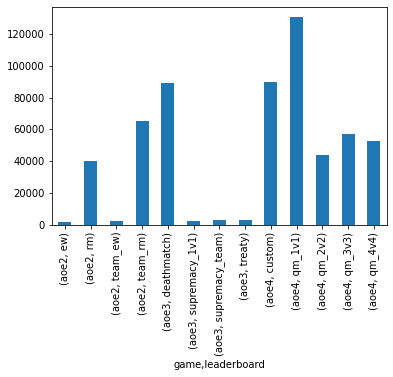

In [21]:
# player base size for activity of leaderboards
# NOTE: because each profile ID can only be active once on a leaderboard,
# we don't need to groupby the profile_id here
collector = {}

for activity_period in ACTIVITY_PERIODS:
    collector[f"{activity_period}d"] = df.loc[LAST_TIMESTAMP & ACTIVITY_PERIOD_FILTERS[f"{activity_period}d"]].groupby(["game", "leaderboard"]).size()
#     collector[f"{activity_period}d"].plot.bar()

print(collector)

TODO: use https://pandas.pydata.org/pandas-docs/version/1.4.0/reference/api/pandas.DataFrame.apply.html to convert to percentage

In [49]:
# Countries overall the games // aoe3 and aoe2 don't have them set as much

collector = {}

# TODO: because each profile ID can be active on more than one leaderboard,
# we need to groupby the profile_id here

for activity_period in ACTIVITY_PERIODS:
    collector[f"{activity_period}d"] = df.loc[[LAST_TIMESTAMP & ACTIVITY_PERIOD_FILTERS[f"{activity_period}d"]], "profile_id"].groupby(["profile_id", "game", "country_code"]).count()

collector["30d"]

KeyError: "None of [Index([(False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, ...)], dtype='object')] are in the [index]"

In [25]:
# Countries of player_ids // aoe3 and aoe2 don't have them set as much

collector = {}

# TODO: because each profile ID can be active on more than one leaderboard,
# we need to groupby the profile_id here

for activity_period in ACTIVITY_PERIODS:
    collector[f"{activity_period}d"] = df.loc[LAST_TIMESTAMP & ACTIVITY_PERIOD_FILTERS[f"{activity_period}d"]].groupby(["profile_id", "country_code"]).size()

print(collector)

{'30d': profile_id                                                                                      country_code
b'\x00\x00-\xcce\xf2\x89\xccX\xd9/vT-\x8b\n\xb0\x0e^\xf9\xdf\x98\xa59\xc8.\xaa\x0b'             GB              1
b'\x00\x00[`\xf9\xb6]\x833\xf7\xcad\x12+\xa0B\xa5\xfa\xbc\x93\x18\x9a\x9a\xb6[@\xfc\x98'        US              1
b'\x00\x00\xbc\xf4\xde\xfft\x1e\xd2\x95Q\xf0\xae\xcae\xfe$ \xb5\xd9Y\x97\xc1}\x9by\x90\xea'     TW              1
b'\x00\x00\xed\x85\xce\x9dV\xbf\xee\xf7]c\xc5\xe2o-m\xb7\x0cS\x19\xad\xab\xb5\x07\xad5a'        DE              1
b'\x00\x01\x05\x90q\x00\xed\x81\xa8\x8c\xf9\xd3\xd96^\xb0\xe5\x04\xed\x1dR\x07.[\xea\xccW\xe7'  MX              3
                                                                                                               ..
b'\xff\xfe\x1b\xd0\xb3\xa4\t\xa7\x9d\x86\xb1\x8be<\x1b\x8a\n\x00C\xcd5<{\xafZ\x85\xeaT'         CN              1
b'\xff\xfe\x9f\x86\xe2\xd2\xad\x8a\xd6\xab\\4\x14g\xb0X\x0c\x04p\x95\xd5dS\x10\xd9+`\

In [42]:
# Countries overall the leaderboards // aoe3 and aoe2 don't have them set as much
collector = {}

# NOTE: because each profile ID can only be active once on a leaderboard,
# we don't need to groupby the profile_id here

for activity_period in ACTIVITY_PERIODS:
#     dat = df.loc[LAST_TIMESTAMP & ACTIVITY_PERIOD_FILTERS[f"{activity_period}d"]].groupby(["game", "leaderboard", "country_code"], as_index=False)
    collector[f"{activity_period}d"] = df.loc[LAST_TIMESTAMP & ACTIVITY_PERIOD_FILTERS[f"{activity_period}d"]].groupby(["game", "leaderboard", "country_code"]).size()
    collector[f"{activity_period}d"] 
#     dat_with_size = pd.merge(
#         left= dat,
#         right=dat_size,
#         on= ["game", "leaderboard", "country_code"]
#     )
#     dat_with_size.sort_values(
#         by=["size", "profile"],
#         ascending=False
#     ).head(3)
#      = dat_with_size
    
print(collector["30d"])

collector["30d"] = collector["30d"].apply(lambda x: x * 3)
collector["30d"]

game  leaderboard  country_code
aoe2  ew           AL                3
                   AR              150
                   AT               11
                   AU               60
                   BD                1
                                  ... 
aoe4  qm_4v4       VA                7
                   VE                1
                   VN               17
                   ZA               30
                   ZM                1
Length: 1383, dtype: int64


game  leaderboard  country_code
aoe2  ew           AL                9
                   AR              450
                   AT               33
                   AU              180
                   BD                3
                                  ... 
aoe4  qm_4v4       VA               21
                   VE                3
                   VN               51
                   ZA               90
                   ZM                3
Length: 1383, dtype: int64

#### Platform data

In [29]:
# Platforms overall the leaderboards with activity
collector = {}

is_relic = df['steam_id'].isnull()


for activity_period in ACTIVITY_PERIODS:
    collector[f"{activity_period}d"] = df.loc[LAST_TIMESTAMP & ACTIVITY_PERIOD_FILTERS[f"{activity_period}d"] & is_relic].groupby(["game", "leaderboard", "profile_id"]).size()

print(collector)


{'30d': game  leaderboard  profile_id                                                                                    
aoe2  ew           b'\x04\x86\x06N\x12\xd0g\xb5\x89\xf0\x87\xf1\xfc\xff\xb7#,\xa5S\xd5\xfe\xb0\xef\xc7\xb0$\xe3@'    1
                   b'\x07=\x11\x18G&5\rYi\xfb\xfe\xf0\x01\xca\xebE\xc4\x1fW5)\x95g}\x13o\xf8'                        1
                   b'\x08\x0c\x1b3\x9c\xbf\xd0\x9ck\x95Ct\x87\xafj\x129\xf3A\xfc\x83\x0b\x99\xfa\xa9\xca\xdf\x87'    1
                   b'\x08U;\xe88\xbcK\x92\x99\xfbC\xd8\xf6\xc1O\x9c\x96\x1c\x92\xc7\xb5\xac\xa2\x8e9\xce:['          1
                   b'\n\xb7\x8b\x8e\x14\x97sW\xccB\xad\x9d\x06c \xce\xc2\x8d\xa1.I\xdb\x8d\xf2\xfaq\xbe\x93'         1
                                                                                                                    ..
aoe4  qm_4v4       b'\xff\xd8g+\x95\x1b\xbb\xd0\x04\x1b\x87z>\xa8\xcf\x0bR~\x10\xcb\xa4t\xe34\xbe\x8a\xe9\x95'       1
                   b'\xff\xdb\x92\xf2k\xa2\x1

In [22]:
timestamped_df = df.groupby(["timestamp"])
timestamped_df.size()

timestamp
2022-01-27 22:17:09.156189    620819
2022-01-28 18:16:09.062004    618489
2022-01-29 19:24:12.630533    619666
2022-01-30 00:42:39.365196    619306
2022-01-31 08:26:48.290235    617015
dtype: int64

In [24]:
# Get only data from newest dataset
newest_df = timestamped_df.get_group(df['timestamp'].max())

In [27]:
newest_df.shape

(617015, 20)

In [45]:
gl_df = newest_df.groupby(["game", "leaderboard"])

In [46]:
gl_df.size()

game  leaderboard   
aoe2  ew                  1813
      rm                 40045
      team_ew             2433
      team_rm            65119
      unranked          172525
aoe3  deathmatch            23
      supremacy_1v1       2987
      supremacy_team      2885
      treaty               613
aoe4  custom            130580
      qm_1v1             43623
      qm_2v2             56827
      qm_3v3             52807
      qm_4v4             44735
dtype: int64

In [47]:
# Countries by game
gl_df.get_group(("aoe2","ew")).value_counts("country_code", normalize=True).head(5)

country_code
US    0.118143
DE    0.091019
AR    0.090416
MX    0.059675
GB    0.045208
dtype: float64

In [48]:
winrates = newest_df.groupby(["game", "leaderboard", "country_code"])

In [89]:
winrates["win_percent"].value_counts(normalize=True).loc[("aoe2","rm","US")].sort_values(ascending=False)

win_percent
50    0.179320
51    0.178854
52    0.092455
49    0.069399
48    0.047275
        ...   
77    0.000466
85    0.000466
91    0.000466
79    0.000233
90    0.000233
Name: win_percent, Length: 79, dtype: float64

In [100]:
winrates["win_percent"].agg(["median", "mean"])

median       mean
game leaderboard country_code                   
aoe2 ew          AL              53.0  49.666667
                 AR              51.0  50.906667
                 AT              54.0  55.454545
                 AU              52.0  53.300000
                 BD              51.0  51.000000
...                               ...        ...
aoe4 qm_4v4      VA              52.0  50.285714
                 VE              43.0  43.000000
                 VN              63.0  62.823529
                 ZA              52.5  49.966667
                 ZM              61.0  61.000000

[1398 rows x 2 columns]

In [101]:
winrates["win_percent"].apply(lambda x: x) # TODO

2478280    69
2478281    66
2478282    73
2478283    57
2478284    58
           ..
3095055    35
3095082    36
3095117    42
3095170    33
3095262    33
Name: win_percent, Length: 308495, dtype: int64